In [ ]:
  import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/knee-osteoarthritis-dataset-with-severity/train'
test_path = '/content/drive/My Drive/Colab Notebooks/knee-osteoarthritis-dataset-with-severity/test'
valid_path = '/content/drive/My Drive/Colab Notebooks/knee-osteoarthritis-dataset-with-severity/val'
list_of_classes=['Healthy', 'Moderate', 'Severe']

In [ ]:
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels')
    for label in df['labels'].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count< n:
            aug_img_count=0
            delta=n - sample_count
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500
working_dir=r'./'
img_size=(224,224)
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


In [ ]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

Healthy     1500
Moderate     500
Severe       500
Name: labels, dtype: int64


In [ ]:
max_samples=500
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


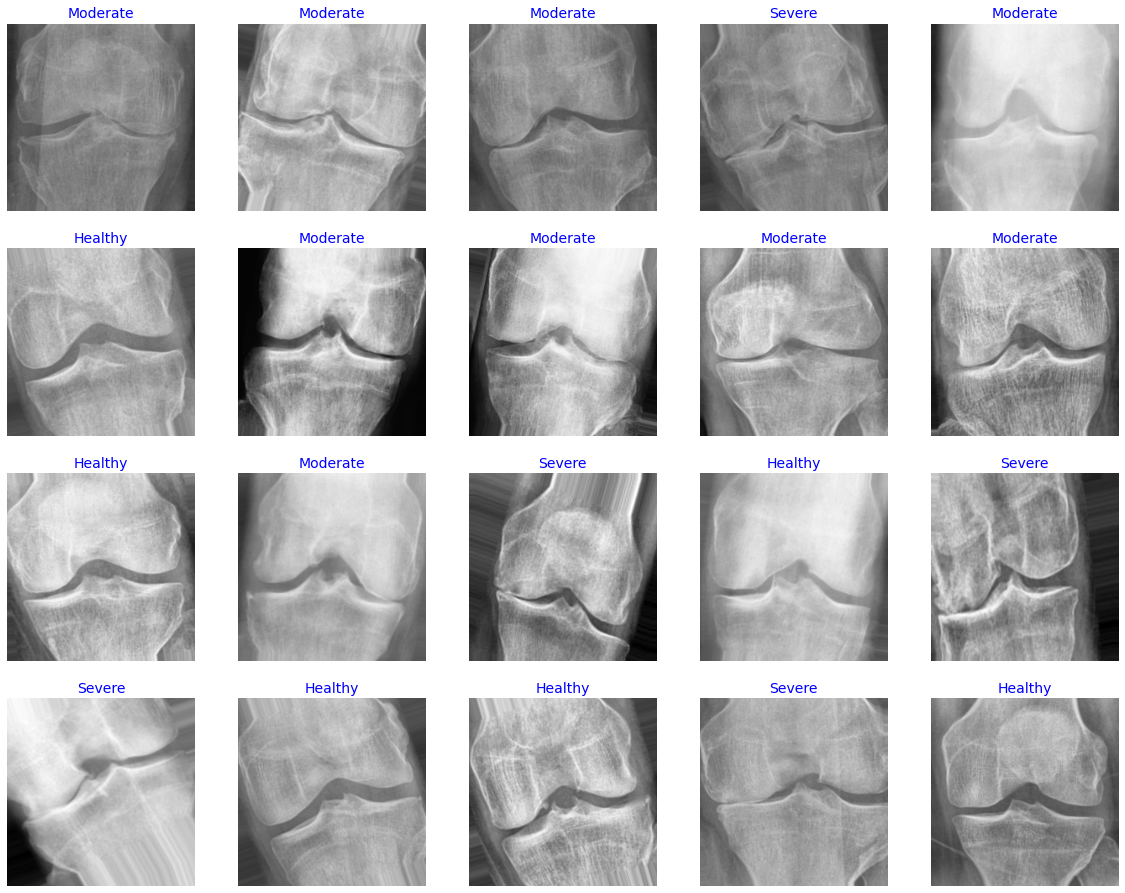

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [ ]:
K.clear_session()
tf.compat.v1.reset_default_graph()
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

115263384/115263384 [==============================] - 6s 0us/step


In [ ]:
epochs=25
ask_epoch=10

In [ ]:
new_history=model.fit(x=train_gen,  epochs=epochs, verbose=1, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 8.4317 - accuracy: 0.6093
 validation loss of  7.9947 is below lowest loss, saving weights from epoch 1   as best weights
75/75 [==============================] - 1266s 17s/step - loss: 8.4317 - accuracy: 0.6093 - val_loss: 7.9947 - val_accuracy: 0.8099
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 6.7364 - accuracy: 0.7287
 validation loss of  6.8062 is below lowest loss, saving weights from epoch 2   as best weights
75/75 [==============================] - 57s 753ms/step - loss: 6.7364 - accuracy: 0.7287 - val_loss: 6.8062 - val_accuracy: 0.7397
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 5.4313 - accuracy: 0.8200
 validation loss of  5.6420 is below lowest loss, saving weights from epoch 3   as best weights
75/7

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests

23/23 [==============================] - 1180s 53s/step
there were 142 errors in 1656 tests for an accuracy of  91.43


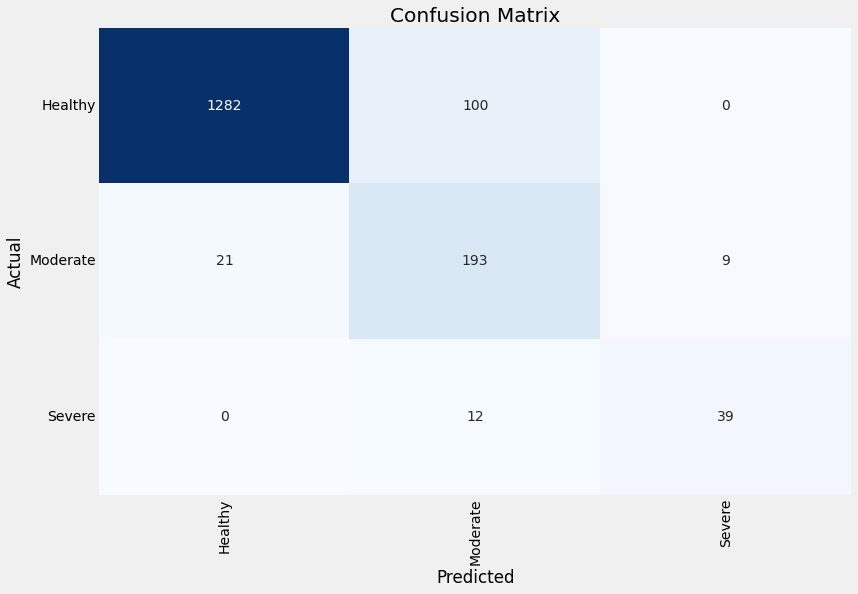

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9839    0.9276    0.9549      1382
    Moderate     0.6328    0.8655    0.7311       223
      Severe     0.8125    0.7647    0.7879        51

    accuracy                         0.9143      1656
   macro avg     0.8097    0.8526    0.8246      1656
weighted avg     0.9313    0.9143    0.9196      1656



In [ ]:
errors, tests=predictor(test_gen, test_steps)

In [ ]:
new_history=model.fit(x=train_gen,  epochs=5, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 0.8484 - accuracy: 0.9780
 validation loss of  1.0960 is above lowest loss of  1.0554 keeping weights from epoch 15 as best weights
75/75 [==============================] - 61s 811ms/step - loss: 0.8484 - accuracy: 0.9780 - val_loss: 1.0960 - val_accuracy: 0.8862
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.9800
 validation loss of  1.1081 is above lowest loss of  1.0554 keeping weights from epoch 15 as best weights
75/75 [==============================] - 57s 764ms/step - loss: 0.7863 - accuracy: 0.9800 - val_loss: 1.1081 - val_accuracy: 0.8499
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.9813
 validation loss of  0.8325 is below lowest loss, saving weights from epoch 3   as 

23/23 [==============================] - 10s 431ms/step
there were 111 errors in 1656 tests for an accuracy of  93.30


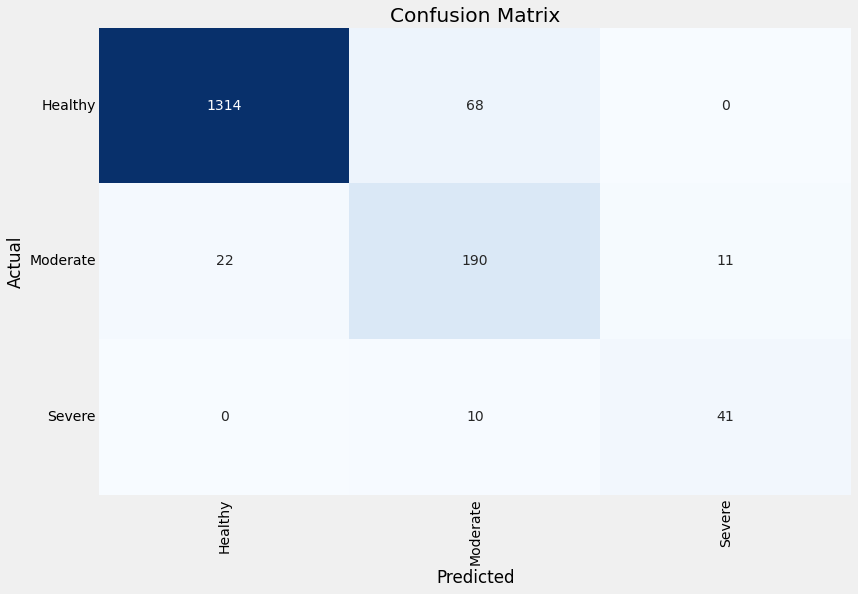

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9835    0.9508    0.9669      1382
    Moderate     0.7090    0.8520    0.7739       223
      Severe     0.7885    0.8039    0.7961        51

    accuracy                         0.9330      1656
   macro avg     0.8270    0.8689    0.8456      1656
weighted avg     0.9406    0.9330    0.9356      1656



In [ ]:
errors, tests=predictor(test_gen, test_steps)

In [ ]:
new_history=model.fit(x=train_gen,  epochs=5, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.9807
 validation loss of  0.6460 is above lowest loss of  0.6032 keeping weights from epoch 5 as best weights
75/75 [==============================] - 58s 765ms/step - loss: 0.3819 - accuracy: 0.9807 - val_loss: 0.6460 - val_accuracy: 0.8910
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.9840
 validation loss of  0.5775 is below lowest loss, saving weights from epoch 2   as best weights
75/75 [==============================] - 57s 760ms/step - loss: 0.3596 - accuracy: 0.9840 - val_loss: 0.5775 - val_accuracy: 0.9104
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9813
 validation loss of  0.5515 is below lowest loss, saving weights from epoch 3   as best weight

23/23 [==============================] - 10s 431ms/step
there were 109 errors in 1656 tests for an accuracy of  93.42


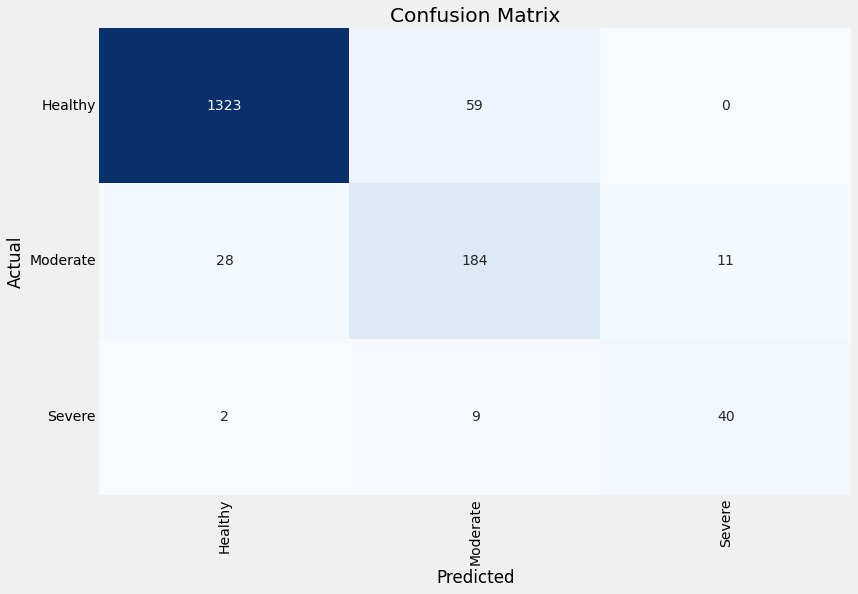

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9778    0.9573    0.9675      1382
    Moderate     0.7302    0.8251    0.7747       223
      Severe     0.7843    0.7843    0.7843        51

    accuracy                         0.9342      1656
   macro avg     0.8308    0.8556    0.8422      1656
weighted avg     0.9385    0.9342    0.9359      1656



In [ ]:
errors, tests=predictor(test_gen, test_steps)

In [ ]:
new_history=model.fit(x=train_gen,  epochs=5, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.9880
 validation loss of  0.5117 is above lowest loss of  0.4998 keeping weights from epoch 4 as best weights
75/75 [==============================] - 58s 768ms/step - loss: 0.2990 - accuracy: 0.9880 - val_loss: 0.5117 - val_accuracy: 0.9177
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9900
 validation loss of  0.6882 is above lowest loss of  0.4998 keeping weights from epoch 4 as best weights
75/75 [==============================] - 58s 762ms/step - loss: 0.2852 - accuracy: 0.9900 - val_loss: 0.6882 - val_accuracy: 0.8632
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9867
 validation loss of  0.6915 is above lowest loss of  0.4998 keeping weights from epoc

23/23 [==============================] - 10s 438ms/step
there were 97 errors in 1656 tests for an accuracy of  94.14


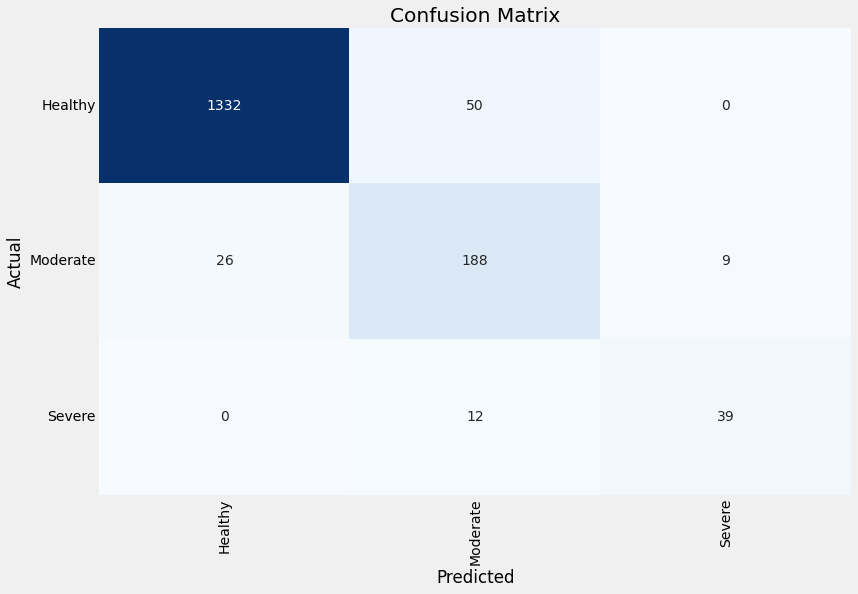

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9809    0.9638    0.9723      1382
    Moderate     0.7520    0.8430    0.7949       223
      Severe     0.8125    0.7647    0.7879        51

    accuracy                         0.9414      1656
   macro avg     0.8485    0.8572    0.8517      1656
weighted avg     0.9449    0.9414    0.9427      1656



In [ ]:
errors, tests=predictor(test_gen, test_steps)

In [ ]:
subject='kneeEffNetB5'
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc)

model was saved as  ./kneeEffNetB5_94.14.h5 94.14 kneeEffNetB5_94.14.h5 ./
